<a href="https://colab.research.google.com/github/jamesbelk0/Metabolic_Syndrome_Classification/blob/main/Classification_Metabolic_Syndrome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification - Metabolic Syndrome

* James Belk
* 03/06/2023

## Import

In [ ]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatplotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import make_column_selector 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

## Classification Metrics
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, f1_score, accuracy_score, classification_report

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

## Load Data

In [ ]:
og_df = pd.read_csv('/content/metabolic_syndrome.csv')
og_df.head()

,seqn,age,sex,marital,income,race,waistcirc,bmi,albuminuria,uralbcr,uricacid,bloodglucose,hdl,triglycerides,metabolicsyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


* The data appears to have loaded correctly

## Functions

In [ ]:
# classification metrics function 
def classification_metrics(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Greens'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    y_pred = model.predict(X_test)
     
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    plt.show()

# Inspect the Data

In [ ]:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   age                2401 non-null   int64  
 2   sex                2401 non-null   object 
 3   marital            2193 non-null   object 
 4   income             2284 non-null   float64
 5   race               2401 non-null   object 
 6   waistcirc          2316 non-null   float64
 7   bmi                2375 non-null   float64
 8   albuminuria        2401 non-null   int64  
 9   uralbcr            2401 non-null   float64
 10  uricacid           2401 non-null   float64
 11  bloodglucose       2401 non-null   int64  
 12  hdl                2401 non-null   int64  
 13  triglycerides      2401 non-null   int64  
 14  metabolicsyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


In [ ]:
# Display the number of rows and columns for the dataframe
og_df.shape
print(f'There are {og_df.shape[0]} rows, and {og_df.shape[1]} columns.')
print(f'The rows represent {og_df.shape[0]} observations, and the columns represent {og_df.shape[1]-1} features and 1 target variable.')

There are 2401 rows, and 15 columns.
The rows represent 2401 observations, and the columns represent 14 features and 1 target variable.


In [ ]:
## Display the descriptive statistics for the numeric columns
display(og_df.describe(include="number"))
## Display the descriptive statistics for the object columns
display(og_df.describe(include="object"))

,seqn,age,income,waistcirc,bmi,albuminuria,uralbcr,uricacid,bloodglucose,hdl,triglycerides
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


,sex,marital,race,metabolicsyndrome
count,2401,2193,2401,2401
unique,2,5,6,2
top,Female,Married,White,No MetSyn
freq,1211,1192,933,1579


### Copy of the Dataset

In [ ]:
# Make a copy of the dataset
df = og_df.copy()

## Clean the Data

### Remove the Unnecessary Columns/Values

#### Duplicates

In [ ]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


* There are no duplicate rows present in the dataset

#### Inspect Column Datatypes for Errors

In [ ]:
# Display column names and datatypes
df.dtypes

seqn                   int64
age                    int64
sex                   object
marital               object
income               float64
race                  object
waistcirc            float64
bmi                  float64
albuminuria            int64
uralbcr              float64
uricacid             float64
bloodglucose           int64
hdl                    int64
triglycerides          int64
metabolicsyndrome     object
dtype: object

* All columns appear to have the appropriate data types

#### Inspect Column Names for Errors

In [ ]:
# Display Column Names
df.columns

Index(['seqn', 'age', 'sex', 'marital', 'income', 'race', 'waistcirc', 'bmi',
       'albuminuria', 'uralbcr', 'uricacid', 'bloodglucose', 'hdl',
       'triglycerides', 'metabolicsyndrome'],
      dtype='object')

* No errors noted

#### Inspect Values for Errors

In [ ]:
# Display the descriptive statistics for the non-numeric columns
display(df.describe(include='number'))
display(df.describe(include='object'))

,seqn,age,income,waistcirc,bmi,albuminuria,uralbcr,uricacid,bloodglucose,hdl,triglycerides
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


,sex,marital,race,metabolicsyndrome
count,2401,2193,2401,2401
unique,2,5,6,2
top,Female,Married,White,No MetSyn
freq,1211,1192,933,1579


* Everything looks to be in order. Missing values are present

### Missing Values

In [ ]:
# Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 436 missing values.


In [ ]:
# Display the count of missing values by column
print(df.isna().sum())

seqn                   0
age                    0
sex                    0
marital              208
income               117
race                   0
waistcirc             85
bmi                   26
albuminuria            0
uralbcr                0
uricacid               0
bloodglucose           0
hdl                    0
triglycerides          0
metabolicsyndrome      0
dtype: int64


In [ ]:
# Display the percentage of missing values by column
print(df.isna().sum()/len(df)*100)

seqn                 0.000000
age                  0.000000
sex                  0.000000
marital              8.663057
income               4.872970
race                 0.000000
waistcirc            3.540192
bmi                  1.082882
albuminuria          0.000000
uralbcr              0.000000
uricacid             0.000000
bloodglucose         0.000000
hdl                  0.000000
triglycerides        0.000000
metabolicsyndrome    0.000000
dtype: float64


* There are missing values in the 'martial', 'waistcirc', 'bmi', and 'income' features.
  * A simple imputer will be needed in the preprocessing steps.
  * Missing for martial, and mean for the 'waistcirc', 'bmi', and 'income'.

# Exploratory Visuals

### Histogram with a breakdown of the individual bloodglucose levels





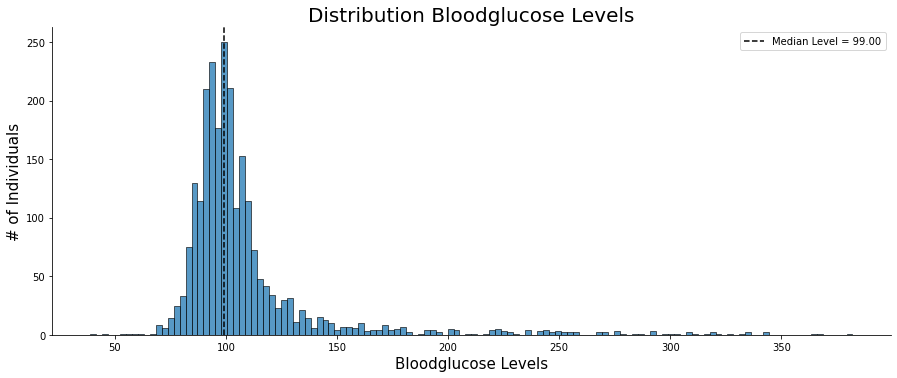

In [ ]:
g = sns.displot(data = df, x = 'bloodglucose', aspect = 2.5);

g.ax.set_title('Distribution Bloodglucose Levels', fontsize = 20);

g.ax.set_xlabel('Bloodglucose Levels', fontsize = 15)
g.ax.set_ylabel('# of Individuals', fontsize = 15)

median = df['bloodglucose'].median()

g.ax.axvline(median, color = 'black', linestyle = '--', label = f'Median Level = {median:,.2f}')
g.ax.legend();

* The histogram shows the median of the bloodglucose levels is 99 and that the vast majority of the individuals under 150.

### Checking for Outliers with a Box Plot

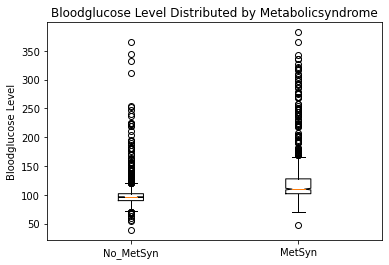

In [ ]:
no_met = df.loc[df['metabolicsyndrome']=='No MetSyn', 'bloodglucose']
met = df.loc[df['metabolicsyndrome']=='MetSyn', 'bloodglucose']
fig,axes = plt.subplots(nrows = 1, ncols = 1)
plt.ylabel('Bloodglucose Level')
plt.title('Bloodglucose Level Distributed by Metabolicsyndrome')
axes.boxplot([no_met, met], notch = True, labels = ['No_MetSyn', 'MetSyn']);

* What the boxplot shows is that the vast majority of individuals have a blood glucose level under 150. The outliers are those anything above 125 on the No_MetSyn side and 175 for the MetSyn side. 

### Correlation Heatmap

<AxesSubplot:>

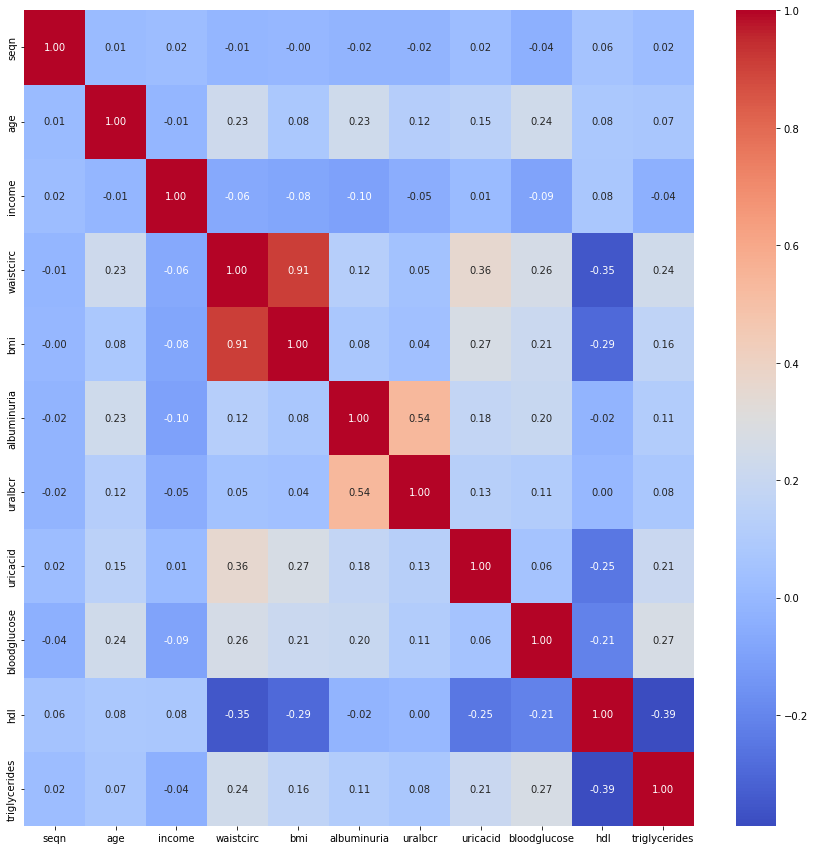

In [ ]:
corr = df.corr()

plt.figure(figsize = (15,15))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')

* Through the heatmap above it shows that out of the data, the features that have the highest impact on the individuals metabolicsyndrome are the following: 
  * Waistcircu
  * BMI
  * Triglycerides
* All three of these featues are direct results of an individuals overall health. If the BMI/Waist Circumference are within healthy ranges the likelihood of everything else being within normal ranges is more likely. 

### Scatterplot Plot

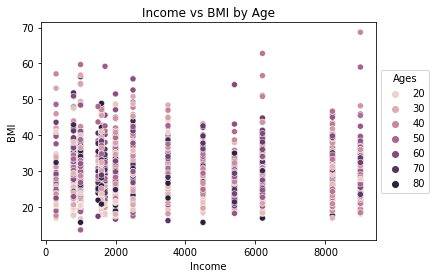

In [ ]:
ax = sns.scatterplot(data = df, x = 'income', y = 'bmi', hue = 'age')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Ages')
plt.title('Income vs BMI by Age')
plt.ylabel('BMI')
plt.xlabel('Income');

* The chart above shows the comparison of income to an indiviauls bmi and does this by age. This shows that income has little influence on the individuals bmi but their age does. 

# Explanatory Visual Trends

In [ ]:
age_income = df.groupby('age')['income'].mean()

### Bar Plot

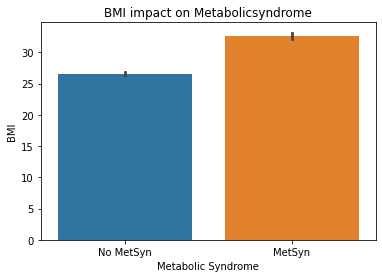

In [ ]:
sns.barplot(data=df, x='metabolicsyndrome', y='bmi')
plt.title('BMI Impact on Metabolicsyndrome')
plt.ylabel('BMI')
plt.xlabel('Metabolic Syndrome');

* The bar plot above shows that the majority of individuals who have metabolicsyndrome have a bmi over 30. Clearly showing that more individuals with metabolicsyndrome have excess weight that should be addressed. 

For an insurance company this would allow them a possibe route to avoid a payout for medication or some other condition. 

### Horizontal Bar Plot

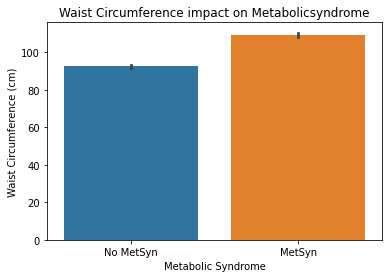

In [ ]:
sns.barplot(data=df, x='metabolicsyndrome', y='waistcirc')
plt.title('Waist Circumference Impact on Metabolicsyndrome')
plt.ylabel('Waist Circumference (cm)')
plt.xlabel('Metabolic Syndrome');

### Line Plot

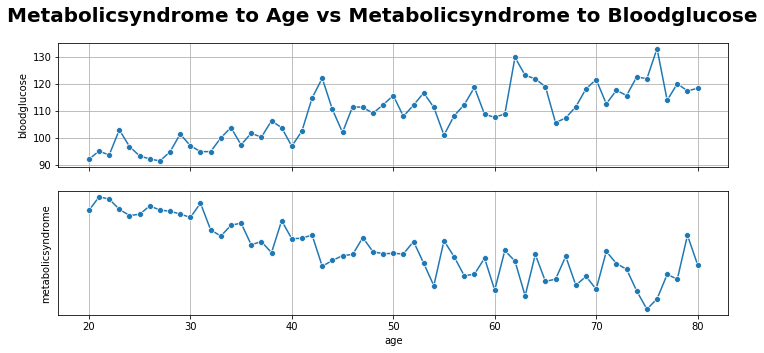

In [ ]:
fig, axes = plt.subplots(nrows = 2, figsize = (12,5), sharex = True)

sns.lineplot(data = df, x = 'age', y = 'bloodglucose', ci = None, marker = 'o', ax = axes[0])
sns.lineplot(data = df, x = 'age', y = 'metabolicsyndrome', ci = None, marker = 'o', ax = axes[1])
[ax.grid() for ax in axes];
fig.suptitle('Metabolicsyndrome to Age vs Metabolicsyndrome to Bloodglucose', fontsize = 20, fontweight = 'bold');

* The chart above shows how as one gets older the general trend of bloodglucose levels rises. This also is a trend of those individuals who have metabolicsyndrome. 

## Check Class Balance

In [ ]:
# Check how many samples of each class are present
df['metabolicsyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: metabolicsyndrome, dtype: int64

In [ ]:
# Check how many samples of each class are present
df['metabolicsyndrome'].value_counts(normalize=True)

No MetSyn    0.657643
MetSyn       0.342357
Name: metabolicsyndrome, dtype: float64

In [ ]:
# Encode 'metabolicsyndrome' column
df['metabolicsyndrome'] = df['metabolicsyndrome'].replace({'No MetSyn': 0, 'MetSyn': 1})

## Validate Data

In [ ]:
# Define features (X) and target (y)
target = 'metabolicsyndrome'
labels = ['No MetSyn', 'MetSyn']

X = df.drop(columns = target, axis=1).copy()
y = df[target].copy()

In [ ]:
# Split the DataSet
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [ ]:
# Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

0    0.656667
1    0.343333
Name: metabolicsyndrome, dtype: float64

In [ ]:
# Check how many samples of each class are present for test
y_test.value_counts(normalize=True)

0    0.660566
1    0.339434
Name: metabolicsyndrome, dtype: float64

## Preprocessing for Machine Learning

### ColumnSelector

In [ ]:
# Instantiate the column selectors
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')

### Imputers

In [ ]:
# Instantiate the imputer 
mean_imputer = SimpleImputer(strategy='mean')
missing_imputer = SimpleImputer(strategy='constant', fill_value='Missing')

# Instantiate the transformer
scaler = StandardScaler()

# Instantiate One Hot Encoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

* mean_imputer to find the average of the missing values in 'waistcirc', 'bmi', and 'income'. 

### Pipeline

In [ ]:
# Create numeric pipeline to scale/impute missing values
numeric_pipe = make_pipeline(mean_imputer, scaler)

### Tuples

In [ ]:
# Create Tuples
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (ohe, cat_selector)

### PCA

In [ ]:
# Create instance for .95 variance in the models
pca = PCA(n_components = .95)

### ColumnTransformer

In [ ]:
# Create the preprocessor
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='drop')

# Modeling

## Logistic Regression Models

### Untuned Model

In [ ]:
# Instance of lr model
log_reg = LogisticRegression()
# Make a pipeline
log_reg_pipe = make_pipeline(preprocessor, log_reg)
# Fit model to pipeline
log_reg_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d8b0>)])),
                ('logisticregression', LogisticRegression())])

In [ ]:
log_reg_train_preds = log_reg_pipe.predict(X_train)
log_reg_test_preds = log_reg_pipe.predict(X_test)

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1182
           1       0.82      0.73      0.78       618

    accuracy                           0.85      1800
   macro avg       0.85      0.83      0.83      1800
weighted avg       0.85      0.85      0.85      1800



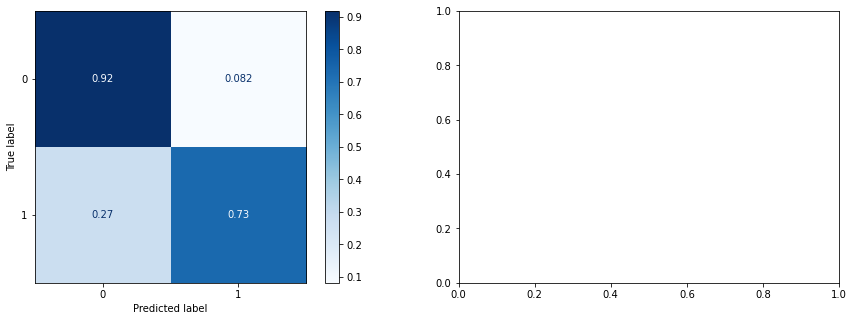

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       397
           1       0.79      0.64      0.70       204

    accuracy                           0.82       601
   macro avg       0.81      0.77      0.79       601
weighted avg       0.82      0.82      0.81       601



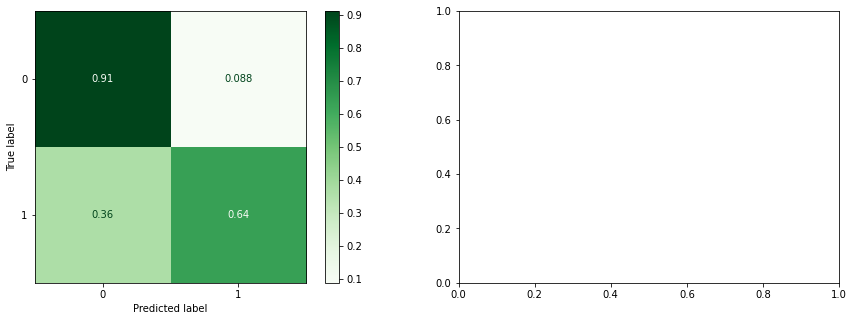

In [ ]:
# Logistic Regression Scores
classification_metrics(log_reg_pipe, X_train,y_train, 
                         cmap='Blues',label='Train Data')
classification_metrics(log_reg_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

### Tuned Model

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

{0.0001: 0.6605657237936772,
 0.001: 0.6605657237936772,
 0.01: 0.8069883527454242,
 0.1: 0.8202995008319468,
 1: 0.8202995008319468,
 10: 0.8169717138103162,
 100: 0.8169717138103162,
 1000: 0.8169717138103162}

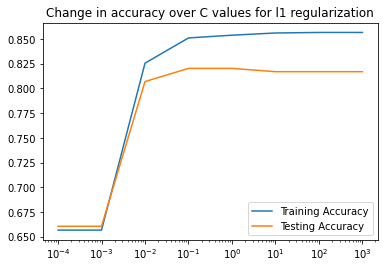

In [ ]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []

for c in c_values:
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg_pipe = make_pipeline(preprocessor, log_reg)
  log_reg_pipe.fit(X_train, y_train)
 
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
 
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
ax.set_xscale('log')

{c:score for c, score in zip(c_values, test_scores)}

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

{0.0001: 0.800332778702163,
 0.001: 0.800332778702163,
 0.01: 0.8202995008319468,
 0.1: 0.8186356073211315,
 1: 0.8153078202995009,
 10: 0.8169717138103162,
 100: 0.8169717138103162,
 1000: 0.8169717138103162}

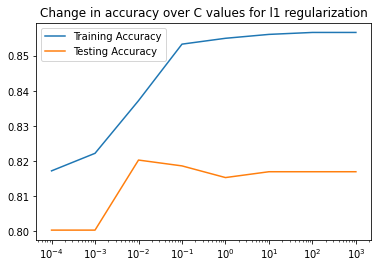

In [ ]:
# L2 Tuning
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []

for c in c_values:
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  log_reg_pipe = make_pipeline(preprocessor, log_reg)
  log_reg_pipe.fit(X_train, y_train)
 
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
 
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
ax.set_xscale('log')

{c:score for c, score in zip(c_values, test_scores)}

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1182
           1       0.82      0.74      0.78       618

    accuracy                           0.86      1800
   macro avg       0.85      0.83      0.84      1800
weighted avg       0.86      0.86      0.85      1800



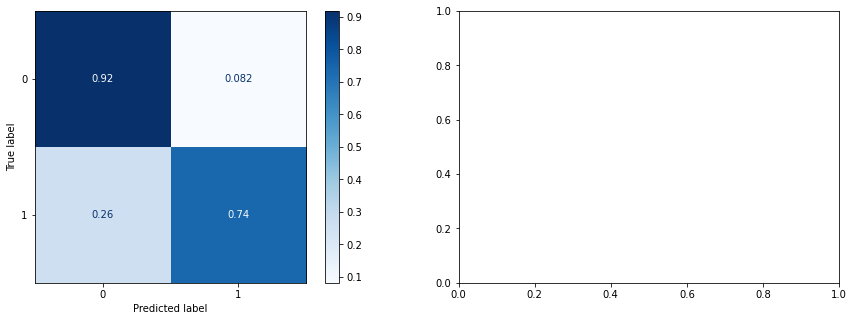

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       397
           1       0.78      0.64      0.70       204

    accuracy                           0.82       601
   macro avg       0.81      0.77      0.79       601
weighted avg       0.81      0.82      0.81       601



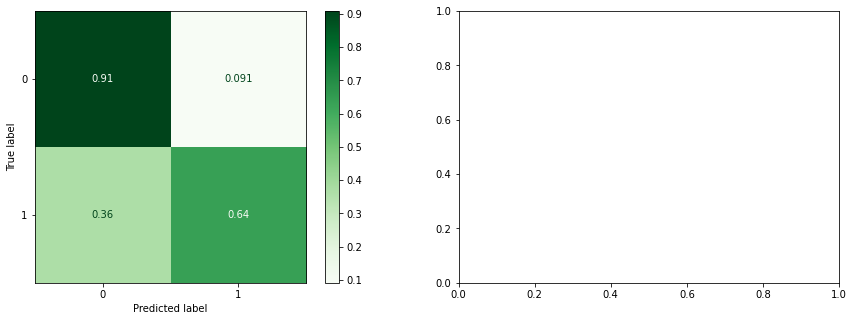

In [ ]:
classification_metrics(log_reg_pipe, X_train,y_train, 
                         cmap='Blues',label='Train Data')
classification_metrics(log_reg_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

### PCA Tuned Model

In [ ]:
# Instance of lr model
log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
# Make a pipeline
log_pca_pipe = make_pipeline(preprocessor, pca, log_reg)
# Fit model to pipeline
log_pca_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d8b0>)])),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression',
                 LogisticRegression(C=1000, max_iter=1000,
                                    solver='liblinear'))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1182
           1       0.82      0.73      0.77       618

    accuracy                           0.85      1800
   macro avg       0.84      0.82      0.83      1800
weighted avg       0.85      0.85      0.85      1800



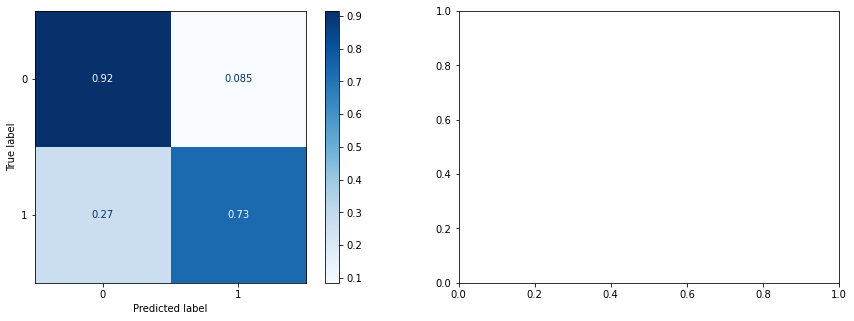

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       397
           1       0.77      0.66      0.71       204

    accuracy                           0.82       601
   macro avg       0.80      0.78      0.79       601
weighted avg       0.81      0.82      0.81       601



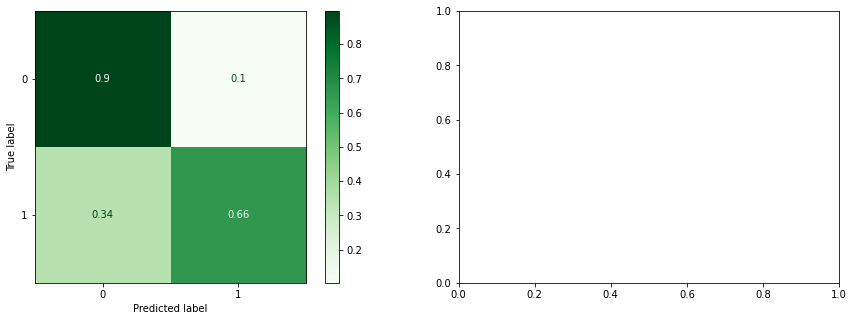

In [ ]:
# Logistic Regression Scores
classification_metrics(log_pca_pipe, X_train,y_train, 
                         cmap='Blues',label='Train Data')
classification_metrics(log_pca_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

* Out of the Four Logistic Regression Models I would recommend the one with the L1 tuning due to it being roughly .05 higher accuracy than the unmoded and L2 models. 

## KNN Models

### Untuned Model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d8b0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1182
           1       1.00      1.00      1.00       618

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



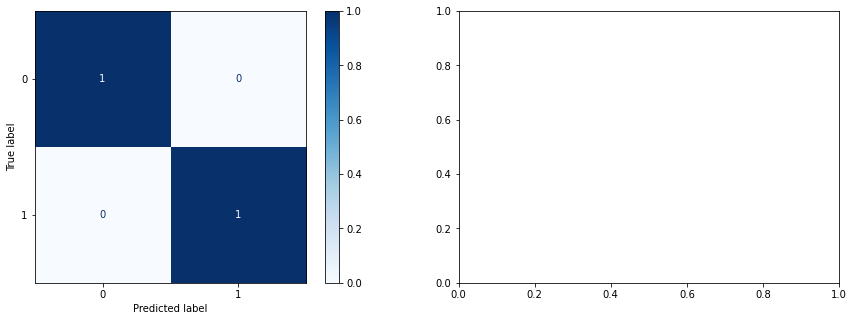

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       397
           1       0.70      0.61      0.65       204

    accuracy                           0.78       601
   macro avg       0.76      0.74      0.74       601
weighted avg       0.77      0.78      0.77       601



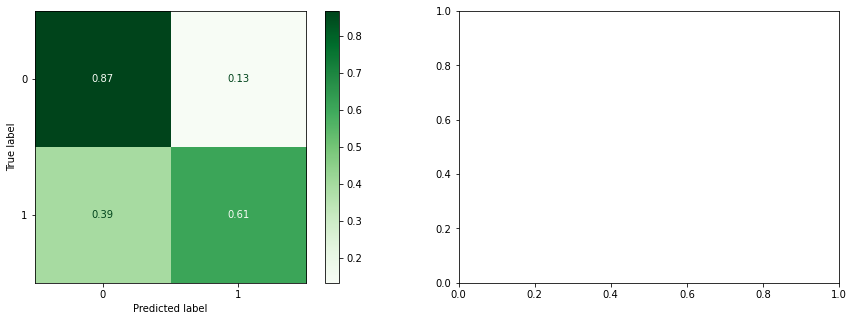

In [ ]:
classification_metrics(knn_pipe, X_train,y_train, 
                         cmap='Blues',label='Train Data')
classification_metrics(knn_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

### Tuned Model

In [ ]:
ks = range(1, 20, 2)
list(ks)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

In [ ]:
scores = []

for k in ks:
  knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=k),)
  scores.append(cross_val_score(knn_pipe, X_train, y_train))

scores

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

[array([0.75555556, 0.75833333, 0.74444444, 0.73055556, 0.76944444]),
 array([0.77777778, 0.78333333, 0.78055556, 0.79166667, 0.775     ]),
 array([0.80555556, 0.78055556, 0.80555556, 0.8       , 0.78611111]),
 array([0.84444444, 0.8       , 0.80555556, 0.80833333, 0.78055556]),
 array([0.83888889, 0.8       , 0.8       , 0.80277778, 0.79444444]),
 array([0.83333333, 0.79444444, 0.8       , 0.79166667, 0.8       ]),
 array([0.83888889, 0.78055556, 0.81388889, 0.79166667, 0.81944444]),
 array([0.83888889, 0.78888889, 0.81388889, 0.79444444, 0.81111111]),
 array([0.82777778, 0.79444444, 0.81111111, 0.80277778, 0.81666667]),
 array([0.83611111, 0.79444444, 0.80833333, 0.8       , 0.81666667])]

In [ ]:
for index, k in enumerate(ks):
  mean_score = np.mean(scores[index])
  print(f'Score for n_neighbors = {k} is {mean_score}')

Score for n_neighbors = 1 is 0.7516666666666667
Score for n_neighbors = 3 is 0.7816666666666666
Score for n_neighbors = 5 is 0.7955555555555555
Score for n_neighbors = 7 is 0.8077777777777779
Score for n_neighbors = 9 is 0.8072222222222223
Score for n_neighbors = 11 is 0.803888888888889
Score for n_neighbors = 13 is 0.8088888888888889
Score for n_neighbors = 15 is 0.8094444444444443
Score for n_neighbors = 17 is 0.8105555555555556
Score for n_neighbors = 19 is 0.8111111111111111


In [ ]:
knn_tuned = KNeighborsClassifier(n_neighbors=19)
knn_tuned_pipe = make_pipeline(preprocessor, knn_tuned)
knn_tuned_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d8b0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=19))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1182
           1       0.82      0.65      0.73       618

    accuracy                           0.83      1800
   macro avg       0.83      0.79      0.80      1800
weighted avg       0.83      0.83      0.83      1800



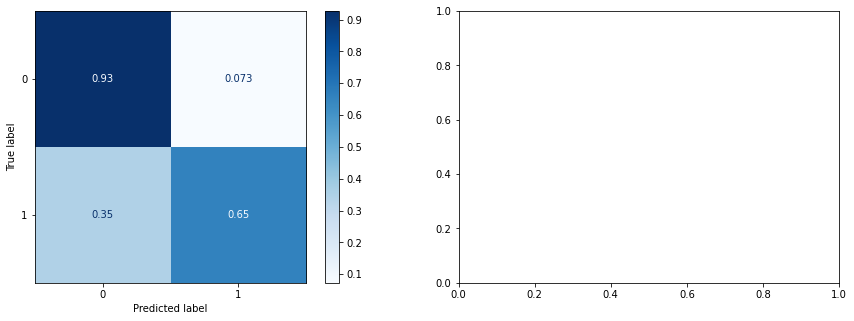

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       397
           1       0.79      0.61      0.69       204

    accuracy                           0.81       601
   macro avg       0.81      0.76      0.78       601
weighted avg       0.81      0.81      0.81       601



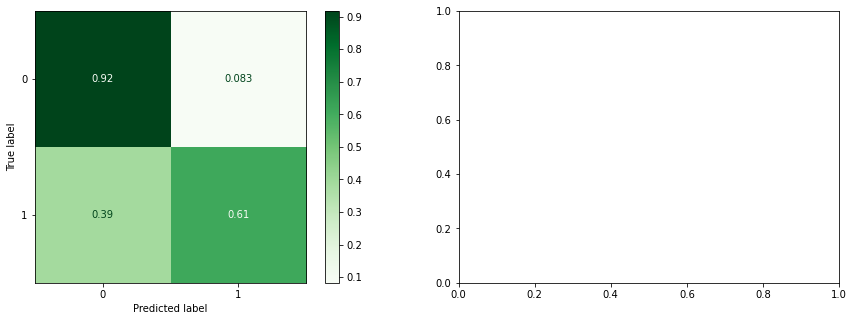

In [ ]:
classification_metrics(knn_tuned_pipe, X_train,y_train, 
                         cmap='Blues',label='Train Data')
classification_metrics(knn_tuned_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

### PCA Tuned Model

In [ ]:
knn_tuned = KNeighborsClassifier(n_neighbors=19)
knn_pca_pipe = make_pipeline(preprocessor, pca, knn_tuned)
knn_pca_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d8b0>)])),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=19))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1182
           1       0.83      0.64      0.72       618

    accuracy                           0.83      1800
   macro avg       0.83      0.79      0.80      1800
weighted avg       0.83      0.83      0.83      1800



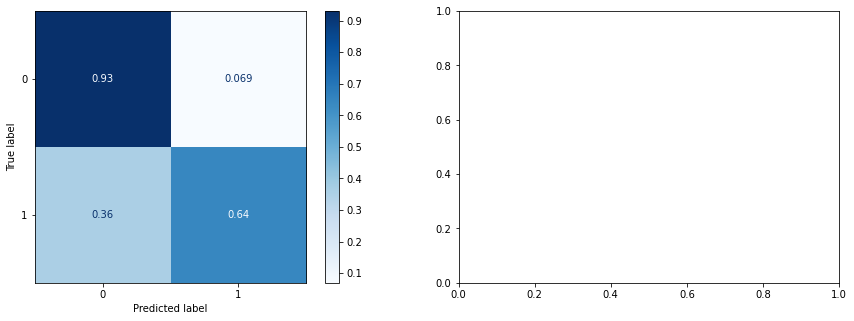

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       397
           1       0.77      0.61      0.68       204

    accuracy                           0.81       601
   macro avg       0.79      0.76      0.77       601
weighted avg       0.80      0.81      0.80       601



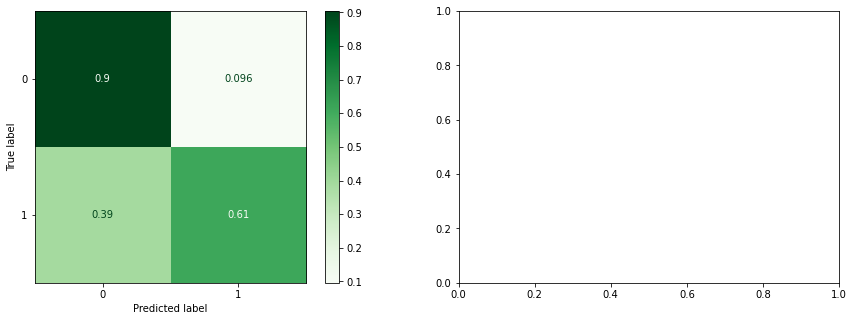

In [ ]:
classification_metrics(knn_pca_pipe, X_train,y_train, 
                         cmap='Blues',label='Train Data')
classification_metrics(knn_pca_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

* Out of the three KNeighbor Models I would recommend the tuned model without the PCA. While it is only marginally better from the Tuned Model with PCA, the time difference did not make much of a difference. The accuracy rate is .3% higher than the Untuned Model with the other metrics showing similar results. 

## Random Forest Models

### Untuned Model

In [ ]:
ran_for = RandomForestClassifier(random_state = 42)
ran_for_pipe = make_pipeline(preprocessor, ran_for)
ran_for_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d8b0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1182
           1       1.00      1.00      1.00       618

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



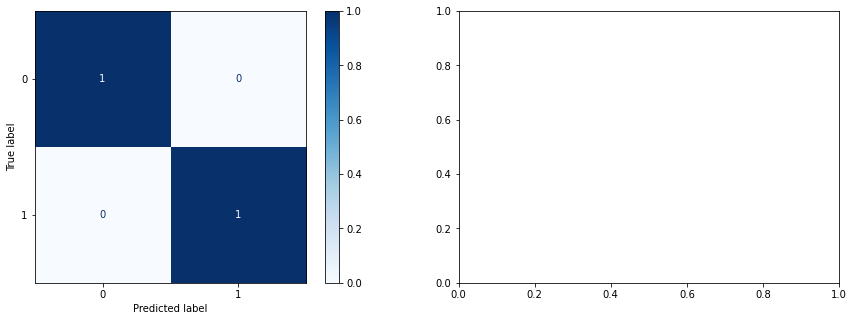

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       397
           1       0.85      0.78      0.81       204

    accuracy                           0.88       601
   macro avg       0.87      0.85      0.86       601
weighted avg       0.88      0.88      0.88       601



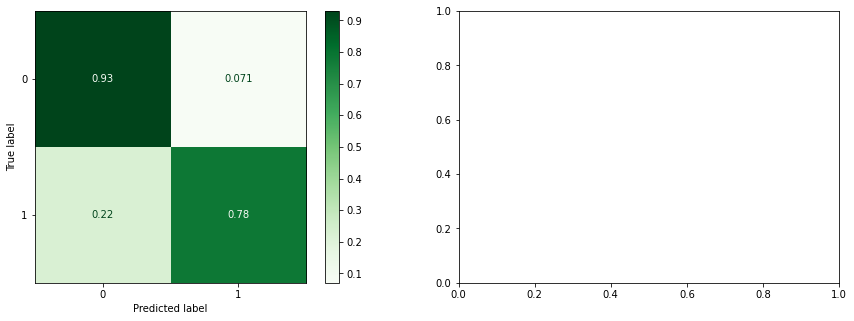

In [ ]:
classification_metrics(ran_for_pipe, X_train,y_train, 
                         cmap='Blues',label='Train Data')
classification_metrics(ran_for_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

### Tuned Model

In [ ]:
param_grid = {'max_depth': range(2, 20, 1),
              'min_samples_leaf': range(1, 10,1),
              'min_samples_split': range(2, 10, 1)
              }

In [ ]:
scores = {}
 
#loop through all combinations of values for all hyperparameters
for d in param_grid['max_depth']:
  for l in param_grid['min_samples_leaf']:
    for s in param_grid['min_samples_split']:
      #fit a model for each combination of hyperparameter values
      model = RandomForestClassifier(max_depth=d,
                                     min_samples_leaf=l,
                                     min_samples_split=s)
      model_pipe = make_pipeline(preprocessor, model)
      model_pipe.fit(X_train, y_train)
      score = model_pipe.score(X_test, y_test)
      #add the model accuracy to a dictionary with the parameter settings as the
      #keys and the accuracies as the values.
      scores[f'depth {d}, min_samples_leaf {l}, min_samples_split {s} accuracy'] = score.round(6) * 100
 
#Display dictionary of scores
scores

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

KeyboardInterrupt: ignored

In [ ]:
# depth 9, min_samples_leaf 5, min_samples_split 3 accuracy': 89.0183
ran_for_tune = RandomForestClassifier(max_depth = 9, min_samples_leaf = 5, min_samples_split = 3)
ran_for_tune_pipe = make_pipeline(preprocessor, ran_for_tune)
ran_for_tune_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d8b0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=5,
                                        min_samples_split=3))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1182
           1       0.93      0.92      0.92       618

    accuracy                           0.95      1800
   macro avg       0.95      0.94      0.94      1800
weighted avg       0.95      0.95      0.95      1800



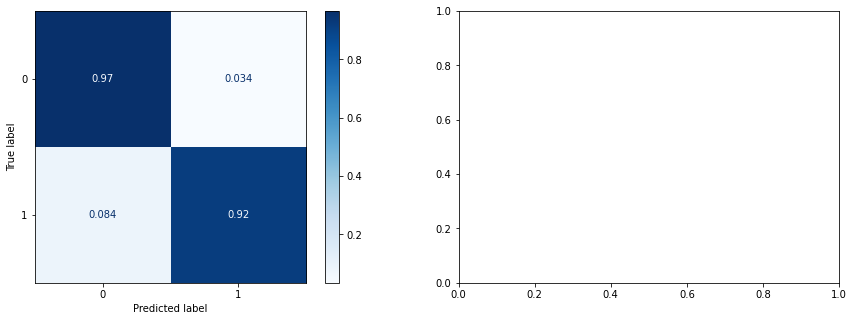

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       397
           1       0.83      0.76      0.79       204

    accuracy                           0.87       601
   macro avg       0.85      0.84      0.85       601
weighted avg       0.86      0.87      0.86       601



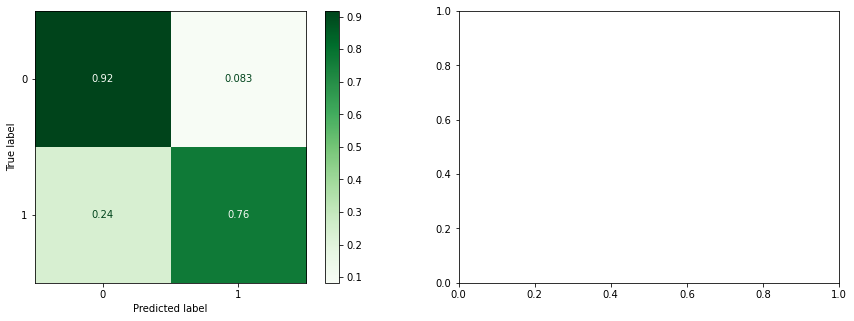

In [ ]:
classification_metrics(ran_for_tune_pipe, X_train, y_train,
                       cmap='Blues', label='Training Data')
classification_metrics(ran_for_tune_pipe, X_test, y_test,
                       cmap='Greens', label='Test Data')

### PCA Tuned Model

In [ ]:
# depth 9, min_samples_leaf 5, min_samples_split 3 accuracy': 89.0183
ran_for_tune = RandomForestClassifier(max_depth = 9, min_samples_leaf = 5, min_samples_split = 3)
ran_for_pca_pipe = make_pipeline(preprocessor, pca, ran_for_tune)
ran_for_pca_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d8b0>)])),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=5,
                                        min_samples_split=3))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1182
           1       0.92      0.86      0.88       618

    accuracy                           0.92      1800
   macro avg       0.92      0.91      0.91      1800
weighted avg       0.92      0.92      0.92      1800



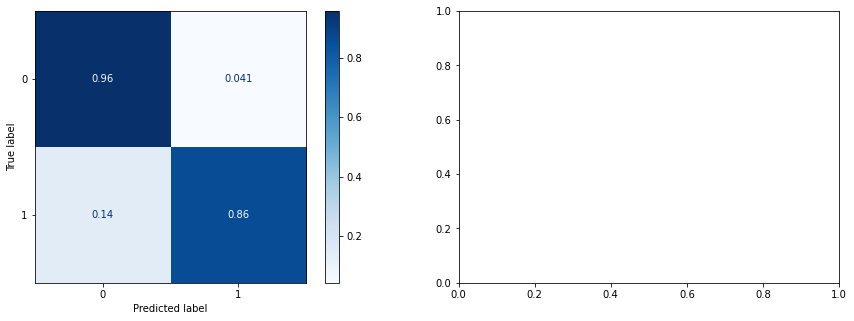

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       397
           1       0.73      0.69      0.71       204

    accuracy                           0.81       601
   macro avg       0.79      0.78      0.78       601
weighted avg       0.81      0.81      0.81       601



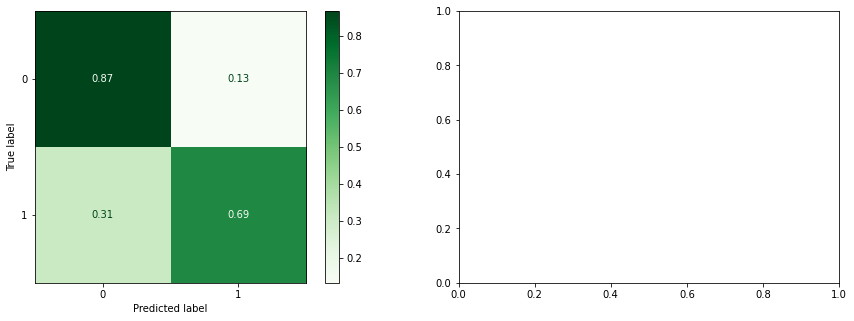

In [ ]:
classification_metrics(ran_for_pca_pipe, X_train, y_train,
                       cmap='Blues', label='Training Data')
classification_metrics(ran_for_pca_pipe, X_test, y_test,
                       cmap='Greens', label='Test Data')

* Out of the Random Forest Models I would have to recommend the Tuned Model without the PCA. Overall the metrics are suprerior and have a lower False Positive/Negative percentages. 

## XGBoost Model

### Untuned Model

In [ ]:
# Create an instance of the model
xgb = XGBClassifier()
# Create a pipeline
xgb_pipe = make_pipeline(preprocessor, xgb)
# Fit the model
xgb_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_trans...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1182
           1       1.00      1.00      1.00       618

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



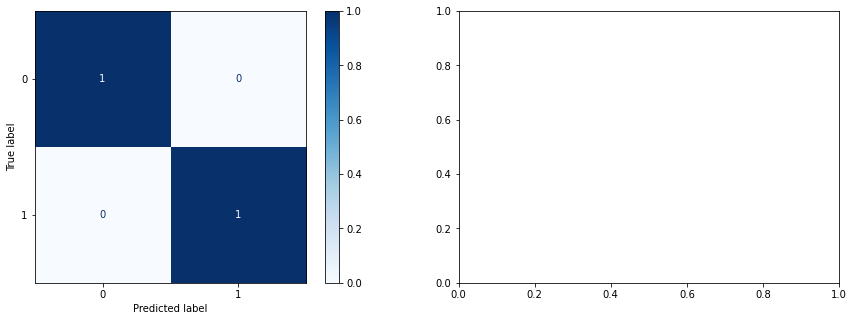

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       397
           1       0.86      0.80      0.83       204

    accuracy                           0.89       601
   macro avg       0.88      0.87      0.87       601
weighted avg       0.89      0.89      0.89       601



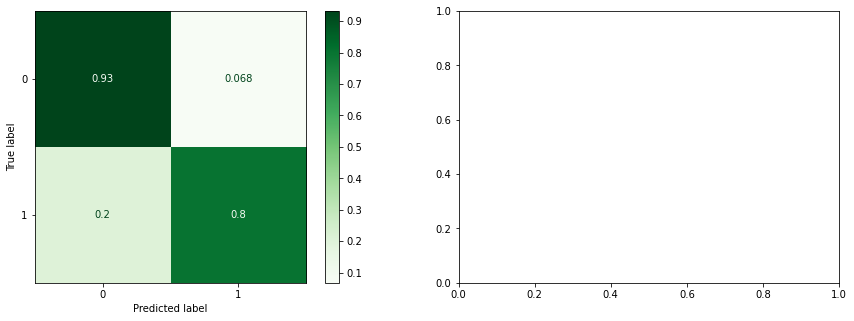

In [ ]:
classification_metrics(xgb_pipe, X_train,y_train, 
                         cmap='Blues', label='Training Data')
classification_metrics(xgb_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

### Tuned Model

In [ ]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
param_grid = {'max_depth': range(2, 20, 1),
              'n_estimators': range(60, 220,40),
              'max_leaves': range(2,20,1)
              }

In [ ]:
scores = {}
 
#loop through all combinations of values for all hyperparameters
for d in param_grid['max_depth']:
  for n in param_grid['n_estimators']:
    for l in param_grid['max_leaves']:
      #fit a model for each combination of hyperparameter values
      model = XGBClassifier(objective = 'binary:logistic', nthread=4, seed=42,max_depth=d, n_estimators=n, max_leaves=l
                            )
      model_pipe = make_pipeline(preprocessor, model)
      model_pipe.fit(X_train, y_train)
      score = model_pipe.score(X_test, y_test)
      #add the model accuracy to a dictionary with the parameter settings as the
      #keys and the accuracies as the values.
      scores[f'depth {d}, n_estimators {n}, max_leaves {l}, accuracy'] = score.round(6) * 100
 
#Display dictionary of scores
scores

In [ ]:
#  'depth 8, n_estimators 140, max_leaves 9, accuracy': 90.0166,
xgb_tune = XGBClassifier(objective = 'binary:logistic', nthread = 4, seed = 42,max_depth = 8, n_estimators = 140, max_leaves = 9)
xgb_tune_pipe = make_pipeline(preprocessor, xgb_tune)
xgb_tune_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_trans...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=9, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=140, n_jobs=None, nthread=4,
                               num_parallel_tree=None, predictor=None, ...))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1182
           1       1.00      1.00      1.00       618

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



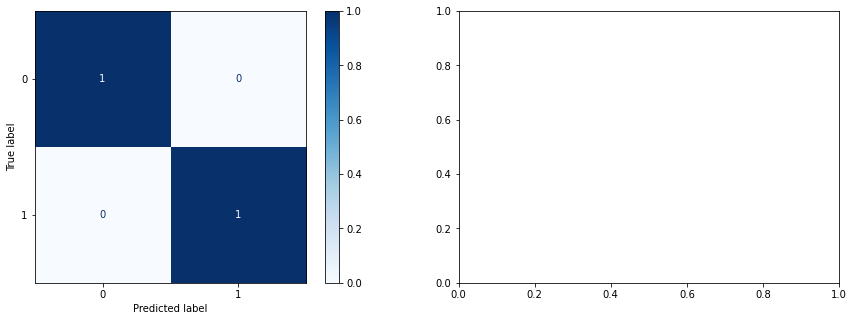

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       397
           1       0.88      0.81      0.85       204

    accuracy                           0.90       601
   macro avg       0.90      0.88      0.89       601
weighted avg       0.90      0.90      0.90       601



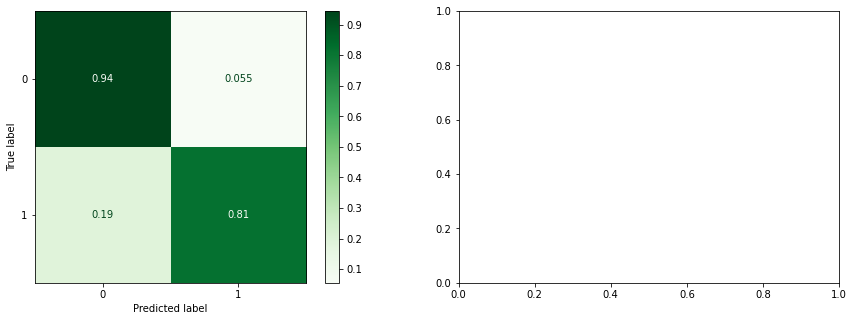

In [ ]:
classification_metrics(xgb_tune_pipe, X_train,y_train, 
                         cmap='Blues', label='Training Data')
classification_metrics(xgb_tune_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

### PCA Tuned Model

In [ ]:
#  'depth 8, n_estimators 140, max_leaves 9, accuracy': 90.0166,
xgb_tune = XGBClassifier(objective = 'binary:logistic', nthread = 4, seed = 42,max_depth = 8, n_estimators = 140, max_leaves = 9)
xgb_pca_pipe = make_pipeline(preprocessor, pca, xgb_tune)
xgb_pca_pipe.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f213e69d550>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_trans...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=9, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=140, n_jobs=None, nthread=4,
                               num_parallel_tree=None, predictor=None, ...))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1182
           1       1.00      1.00      1.00       618

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



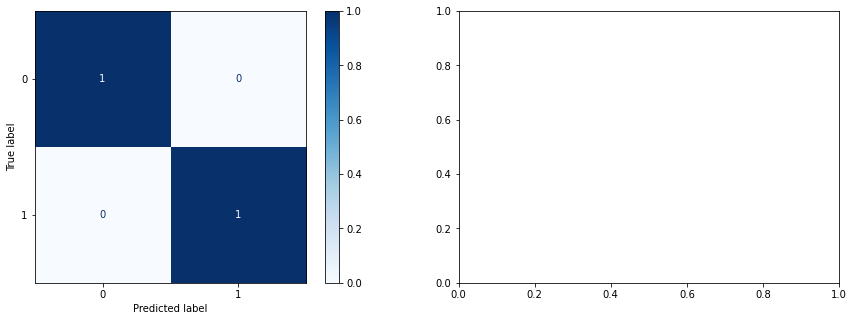

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       397
           1       0.72      0.72      0.72       204

    accuracy                           0.81       601
   macro avg       0.79      0.79      0.79       601
weighted avg       0.81      0.81      0.81       601



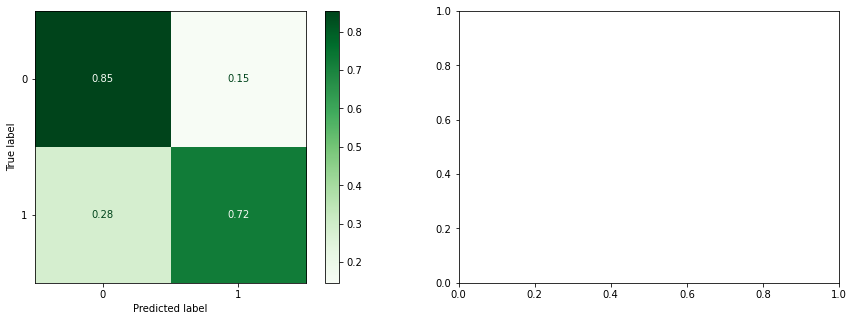

In [ ]:
classification_metrics(xgb_pca_pipe, X_train,y_train, 
                         cmap='Blues', label='Training Data')
classification_metrics(xgb_pca_pipe, X_test,y_test, 
                         cmap='Greens',label='Test Data')

# Production Model Evaluation

* Based on the above models, I would recommend the the Tuned XGBoost Model without the PCA due to its accuracy of .90 topping off all of the previous models accuracy rates. This holds true for the other metrics as well.

* The False Positive rating of .055 also is lower than all previous models presented. The False Negative rate is also at a lower percentage than the other XGBoost Models at .19 compared to .20. 

  * The parameters that were tuned were the following: max_depth, n_estimators, and max_leaves.

    *Precision: .91

    *Recall: .94

    *F1-Score: .93

    *Accuracy: .90

* The benefits of a lower False Negative rate allows for the possiblities of a metabolicsyndrome from going uncaught greatly outshines the possibility of a False Positive in this case. Guiding an individual towards a healthier lifestyle will only benefit the individual in the long term and allow for the possibility of a greater standard of life. 
* A False Positive can also be checked again where as an individual who has a False Negative might miss a possibly life threatening diagnosis. 